# In this analysis, we will use Random Forest and Gradient Boosting ML Models to predict customer churn. This analysis will include data preprocessing, analysis, training models, and finally evaluating those models.

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.tree import plot_tree

# ML Models
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier


plt.style.use('fivethirtyeight')

In [2]:
# Read in Data
df = pd.read_csv("Customer-Churn-Records.csv", index_col = 'RowNumber')
df["Exited"] = np.where(df["Exited"] == 1, "Return", "Churn")

print(df.isna().sum())
print()
df

CustomerId            0
Surname               0
CreditScore           0
Geography             0
Gender                0
Age                   0
Tenure                0
Balance               0
NumOfProducts         0
HasCrCard             0
IsActiveMember        0
EstimatedSalary       0
Exited                0
Complain              0
Satisfaction Score    0
Card Type             0
Point Earned          0
dtype: int64



,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Complain,Satisfaction Score,Card Type,Point Earned
RowNumber,,,,,,,,,,,,,,,,,
1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,Return,1,2,DIAMOND,464
2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,Churn,1,3,DIAMOND,456
3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,Return,1,3,DIAMOND,377
4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,Churn,0,5,GOLD,350
5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,Churn,0,5,GOLD,425
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9996,15606229,Obijiaku,771,France,Male,39,5,0.00,2,1,0,96270.64,Churn,0,1,DIAMOND,300
9997,15569892,Johnstone,516,France,Male,35,10,57369.61,1,1,1,101699.77,Churn,0,5,PLATINUM,771
9998,15584532,Liu,709,France,Female,36,7,0.00,1,0,1,42085.58,Return,1,3,SILVER,564


In [3]:
# Drop uneeded/redundant columns
df.drop(columns=['CustomerId', 'Surname', 'Complain'], inplace = True)

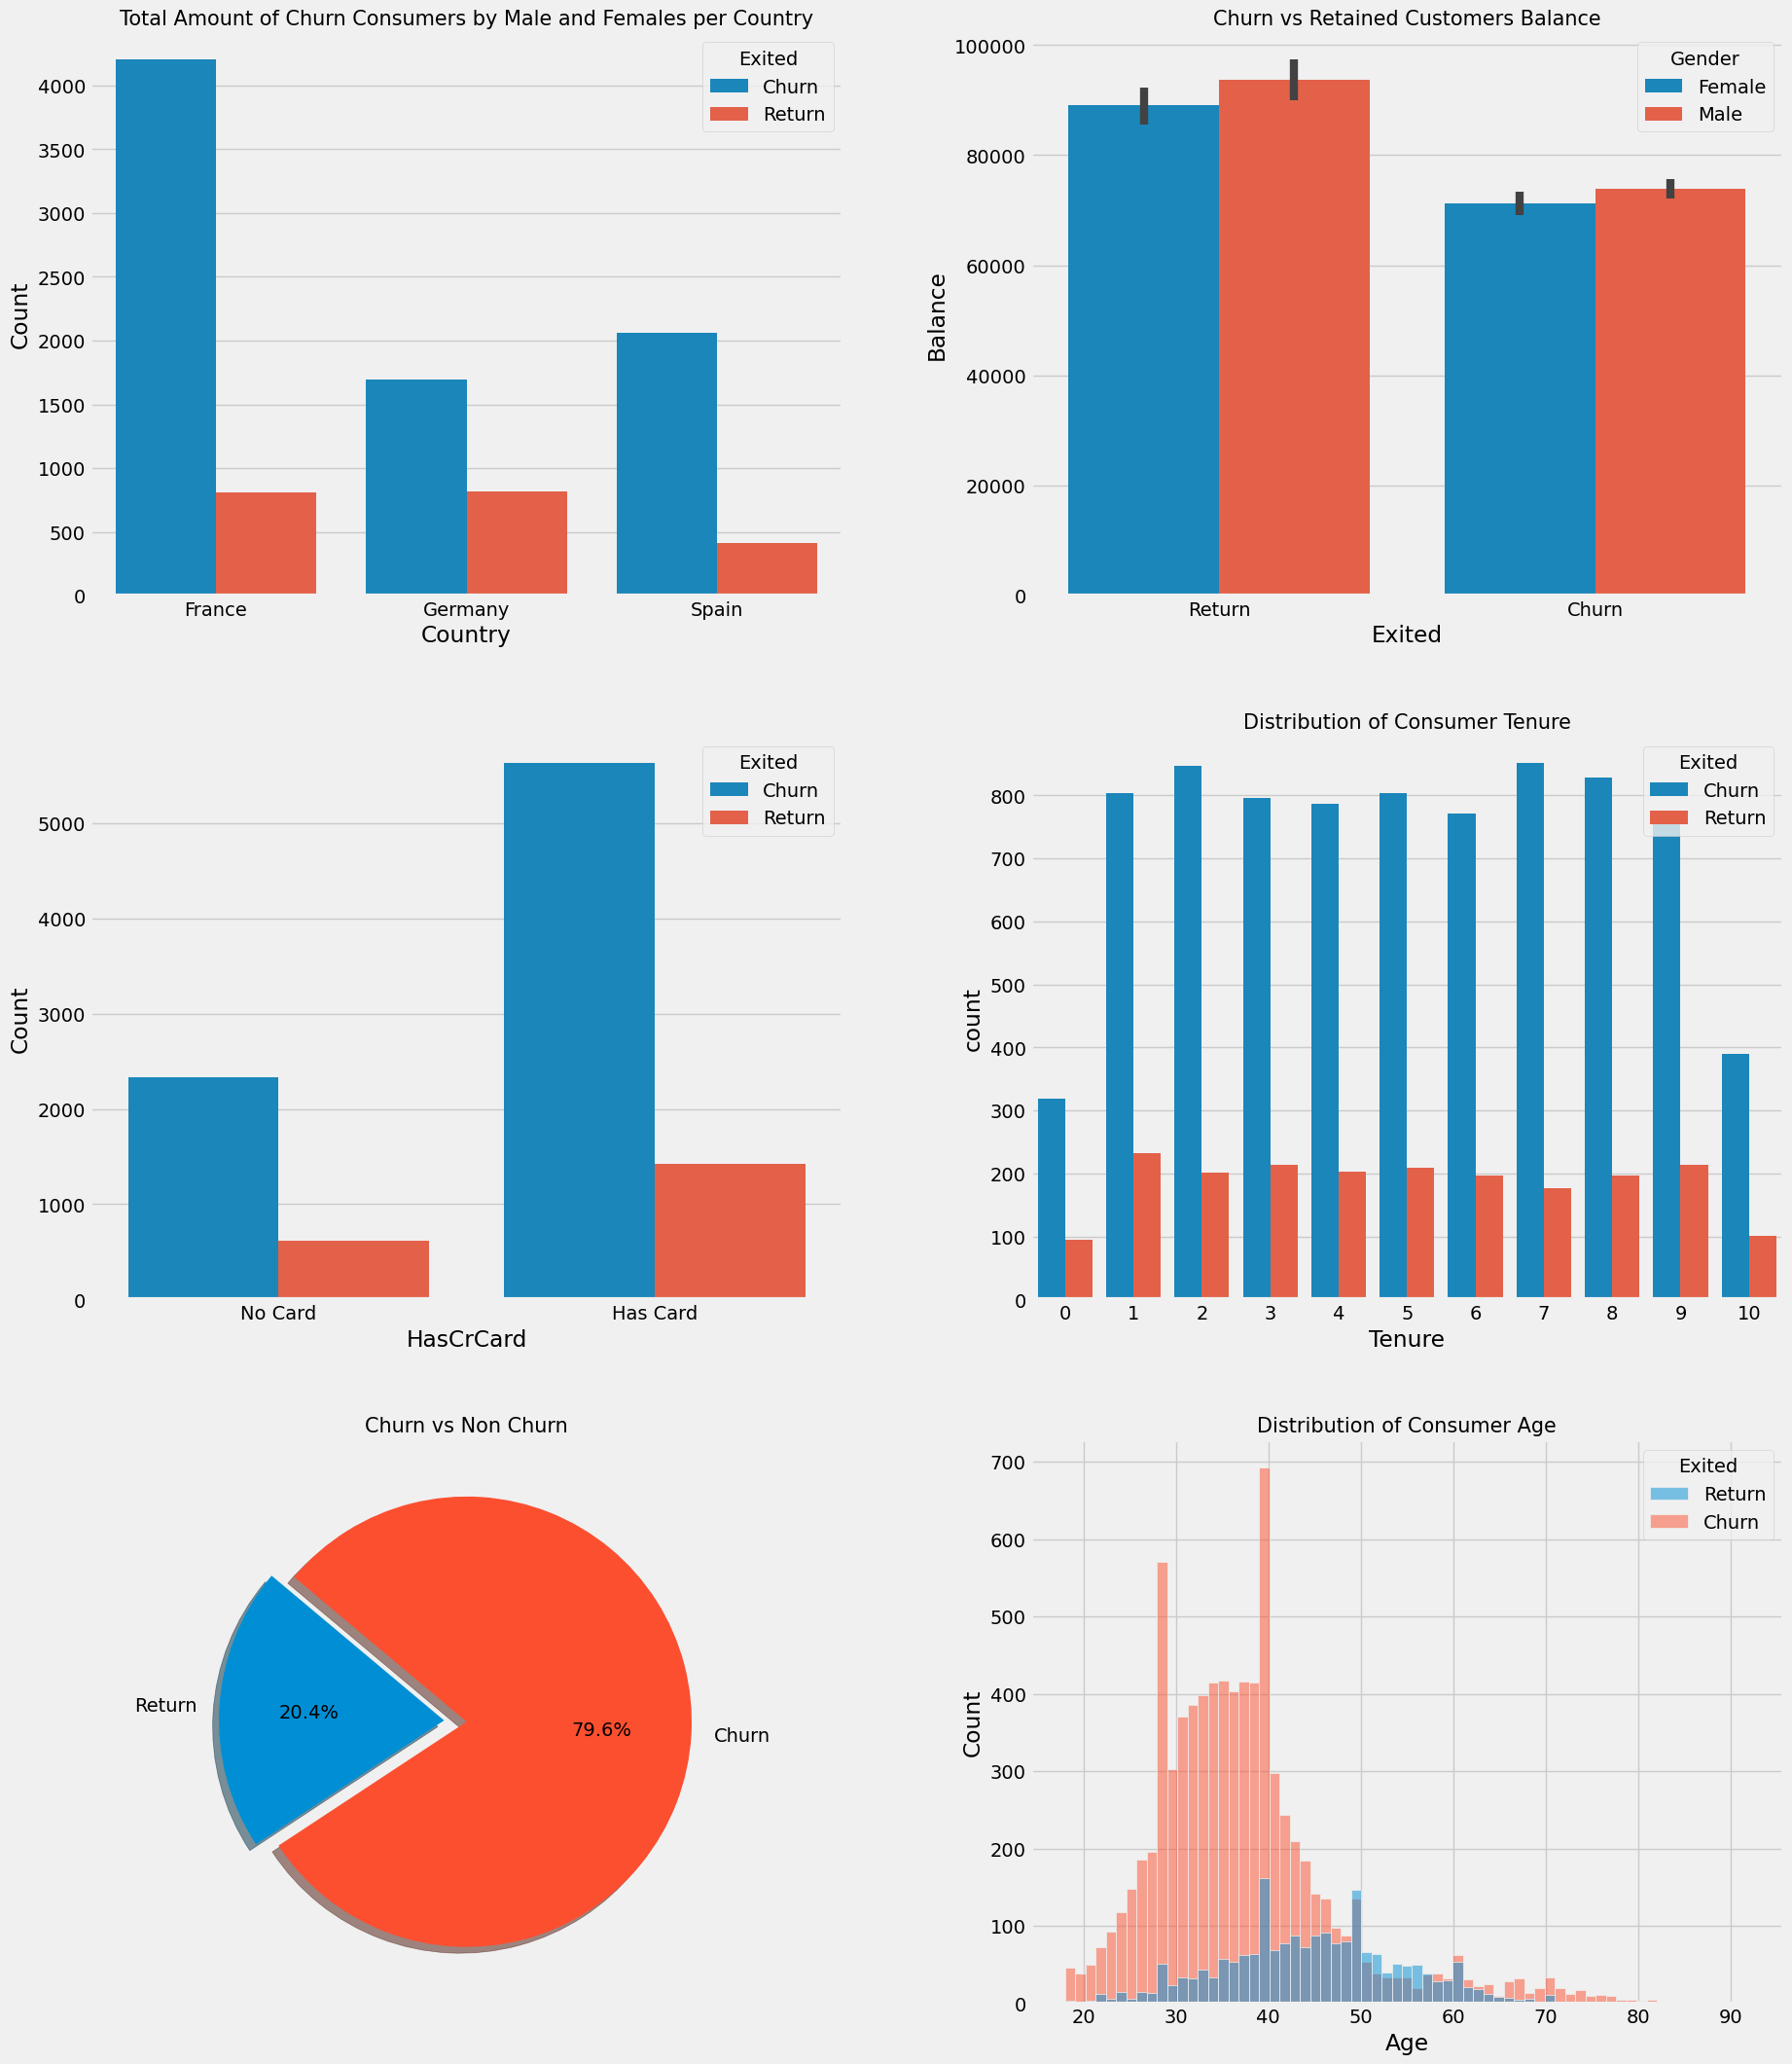

In [4]:
# Let create some visualizations to better understand the data
fig, ax = plt.subplots(3, 2, figsize=(20, 25))


# Figure one: Bar plot of Points Earned based off of geography and gender
grouped = df.groupby(['Geography', 'Exited']).size().reset_index(name='Count')
sns.barplot(data=grouped, x='Geography', y='Count', hue='Exited', ax=ax[0,0])
            
ax[0,0].set_title("Total Amount of Churn Consumers by Male and Females per Country", fontsize=15)
ax[0,0].set_xlabel("Country")


# Figure two: What is the salary of people who do churn(are or arnt "excited")
sns.barplot(x="Exited", y ='Balance', data=df, ax=ax[0,1], hue = 'Gender')
ax[0, 1].set_title("Churn vs Retained Customers Balance", fontsize = 15)


# Figure 3: How many people churn per country
grouped = df.groupby(['HasCrCard', 'Exited']).size().reset_index(name='Count')
grouped['HasCrCard'] = grouped['HasCrCard'].map({0: 'No Card', 1: 'Has Card'})

sns.barplot(data=grouped, x = "HasCrCard", y = 'Count', hue='Exited', ax = ax[1,0])


# Figure 4: Count Plot showing Tenure and Churn 
sns.countplot(x='Tenure', ax=ax[1,1], hue='Exited', data=df)
ax[1,1].set_title("Distribution of Consumer Tenure", fontsize=15)


# Figure 5 Pie Chart: 
labels = df.Exited.unique() ## Return, Churn
sizes = [
    len(df[df.Exited == labels[0]]),
    len(df[df.Exited == labels[1]])
]
colors = ['lightskyblue', 'lightcoral']
explode = (0.1, 0)

ax[2,0].pie(sizes, explode=explode, labels = labels, autopct='%1.1f%%', shadow=True, startangle=140)
ax[2,0].set_title("Churn vs Non Churn", fontsize=15)

# Figure 6: Distribution of Churn based off of age
sns.histplot(df, x='Age', hue = 'Exited', ax=ax[2,1]s)
ax[2,1].set_title("Distribution of Consumer Age", fontsize=15)


plt.subplots_adjust(wspace=0.25, hspace=0.25)
plt.show()

## Now we will use ML(random forest and gradient boosting) to predict consumer churn. We will split, train, and test the data, aswell as provide visualizations. First, however, we must do data preprocessing so the data is ready to be split and is in the correct format.

In [5]:
# Change 'Exited' column to 1's and 0's
df['Exited'] = np.where(df.Exited == 'Return', 1, 0)

# Preview data
display(df.head())

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Satisfaction Score,Card Type,Point Earned
RowNumber,,,,,,,,,,,,,,
1,619,France,Female,42,2,0.00,1,1,1,101348.88,1,2,DIAMOND,464
2,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0,3,DIAMOND,456
3,502,France,Female,42,8,159660.80,3,1,0,113931.57,1,3,DIAMOND,377
4,699,France,Female,39,1,0.00,2,0,0,93826.63,0,5,GOLD,350
5,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0,5,GOLD,425


In [6]:
# As we can see, we must transform 'Card Type', 'Geography', and 'Gender' cols to numeric. Also, NumOfProducts, 'Tenure', and Satisfaction Score
# are categorical variables, so we must take that into account
# We will use dummy variables to do this

In [7]:
cols_to_transform = ['Geography', 'Card Type', 'Gender', 'NumOfProducts', 'Satisfaction Score', 'Tenure'] # Nessecary cols to transform

# Loop through cols
for col in cols_to_transform:
    temp = pd.get_dummies(df[col], prefix=f'{col}_', drop_first=True).astype('Int64')
    df.drop(columns = col, inplace = True) # Drop col

    df = pd.concat([df, temp], axis = 1)

df.head()

,CreditScore,Age,Balance,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Point Earned,Geography__Germany,Geography__Spain,...,Tenure__1,Tenure__2,Tenure__3,Tenure__4,Tenure__5,Tenure__6,Tenure__7,Tenure__8,Tenure__9,Tenure__10
RowNumber,,,,,,,,,,,,,,,,,,,,,
1,619,42,0.00,1,1,101348.88,1,464,0,0,...,0,1,0,0,0,0,0,0,0,0
2,608,41,83807.86,0,1,112542.58,0,456,0,1,...,1,0,0,0,0,0,0,0,0,0
3,502,42,159660.80,1,0,113931.57,1,377,0,0,...,0,0,0,0,0,0,0,1,0,0
4,699,39,0.00,0,0,93826.63,0,350,0,0,...,1,0,0,0,0,0,0,0,0,0
5,850,43,125510.82,1,1,79084.10,0,425,0,1,...,0,1,0,0,0,0,0,0,0,0


In [8]:
# Split data 
X = df.drop(columns = 'Exited')
y = df.Exited

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size = 0.3, stratify=y) 

print("******************Training Data******************")
print(f"X Train:")
display(X_train.head())
print(f"Y Train:\n{y_train.head()}")
print()

print("******************Testing Data******************")
print(f"X Test:")
display(X_test.head())
print(f"Y Test:\n{y_test.head()}")

******************Training Data******************
X Train:


,CreditScore,Age,Balance,HasCrCard,IsActiveMember,EstimatedSalary,Point Earned,Geography__Germany,Geography__Spain,Card Type__GOLD,...,Tenure__1,Tenure__2,Tenure__3,Tenure__4,Tenure__5,Tenure__6,Tenure__7,Tenure__8,Tenure__9,Tenure__10
RowNumber,,,,,,,,,,,,,,,,,,,,,
7681,808,25,0.0,0,1,23180.37,387,0,1,1,...,0,0,0,0,0,0,1,0,0,0
1838,561,56,152759.0,1,0,133167.11,377,0,0,1,...,0,0,0,0,0,0,1,0,0,0
2921,696,33,0.0,1,1,73371.65,348,0,0,0,...,0,0,0,1,0,0,0,0,0,0
2643,637,22,98800.0,1,0,122865.55,430,0,1,0,...,0,0,0,0,1,0,0,0,0,0
4801,690,39,0.0,1,0,160532.88,517,0,0,0,...,0,0,0,0,0,1,0,0,0,0


Y Train:
RowNumber
7681    0
1838    1
2921    0
2643    0
4801    0
Name: Exited, dtype: int32

******************Testing Data******************
X Test:


,CreditScore,Age,Balance,HasCrCard,IsActiveMember,EstimatedSalary,Point Earned,Geography__Germany,Geography__Spain,Card Type__GOLD,...,Tenure__1,Tenure__2,Tenure__3,Tenure__4,Tenure__5,Tenure__6,Tenure__7,Tenure__8,Tenure__9,Tenure__10
RowNumber,,,,,,,,,,,,,,,,,,,,,
6674,729,36,109106.8,0,0,121311.12,456,0,0,0,...,0,0,0,0,0,0,0,1,0,0
5573,565,34,0.0,1,1,63173.64,244,0,0,1,...,0,0,0,0,0,1,0,0,0,0
4479,549,31,0.0,0,1,25684.85,427,0,0,0,...,0,0,0,1,0,0,0,0,0,0
8247,663,24,0.0,1,1,166310.82,943,0,0,0,...,0,0,0,0,0,0,1,0,0,0
9546,721,57,0.0,1,1,195940.96,226,0,1,0,...,1,0,0,0,0,0,0,0,0,0


Y Test:
RowNumber
6674    0
5573    0
4479    0
8247    0
9546    0
Name: Exited, dtype: int32


In [9]:
rfr = RandomForestClassifier(random_state=42)
rfr

RandomForestClassifier(random_state=42)

In [10]:
# KFold for spliting data
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Params for model
param_grid = {
    "n_estimators":np.arange(100, 525, 25)
}

# Randomly Search for best model
rcv = RandomizedSearchCV(rfr, param_grid, cv=kf, verbose=1, n_jobs=-1)
rcv.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


RandomizedSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
                   estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
                   param_distributions={'n_estimators': array([100, 125, 150, 175, 200, 225, 250, 275, 300, 325, 350, 375, 400,
       425, 450, 475, 500])},
                   verbose=1)

In [11]:
# Display rcv process
data = pd.DataFrame(rcv.cv_results_)
display(data.head().sort_values('rank_test_score'))

# Print results of best model
print(rcv.best_params_)
print(rcv.best_score_)
print(rcv.best_estimator_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
4,4.134322,0.036193,0.142196,0.004178,375,{'n_estimators': 375},0.863571,0.860714,0.862857,0.860714,0.850714,0.859714,0.004642,1
1,32.485862,59.534428,59.936488,73.123716,125,{'n_estimators': 125},0.860000,0.861429,0.863571,0.859286,0.851429,0.859143,0.004126,5
2,784.646282,0.610624,0.178315,0.028182,425,{'n_estimators': 425},0.863571,0.860714,0.862143,0.858571,0.850714,0.859143,0.004527,6
0,155.245474,0.238327,156.053381,311.494769,250,{'n_estimators': 250},0.863571,0.860000,0.865000,0.857143,0.849286,0.859000,0.005581,7
3,316.990192,381.827043,0.182575,0.020036,475,{'n_estimators': 475},0.862143,0.860714,0.861429,0.860000,0.850000,0.858857,0.004486,8


{'n_estimators': 375}
0.8597142857142858
RandomForestClassifier(n_estimators=375, random_state=42)


In [12]:
rfr_best = rcv.best_estimator_
rfr_best

RandomForestClassifier(n_estimators=375, random_state=42)

In [13]:
# Fit best model to data
rfr_best.fit(X_train, y_train)

# Score Manually
print(f"Training Score: {rfr_best.score(X_train, y_train)}")
print(f"Testing Score: {rfr_best.score(X_test, y_test)}")

Training Score: 1.0
Testing Score: 0.8726666666666667


Number of estimators: 375


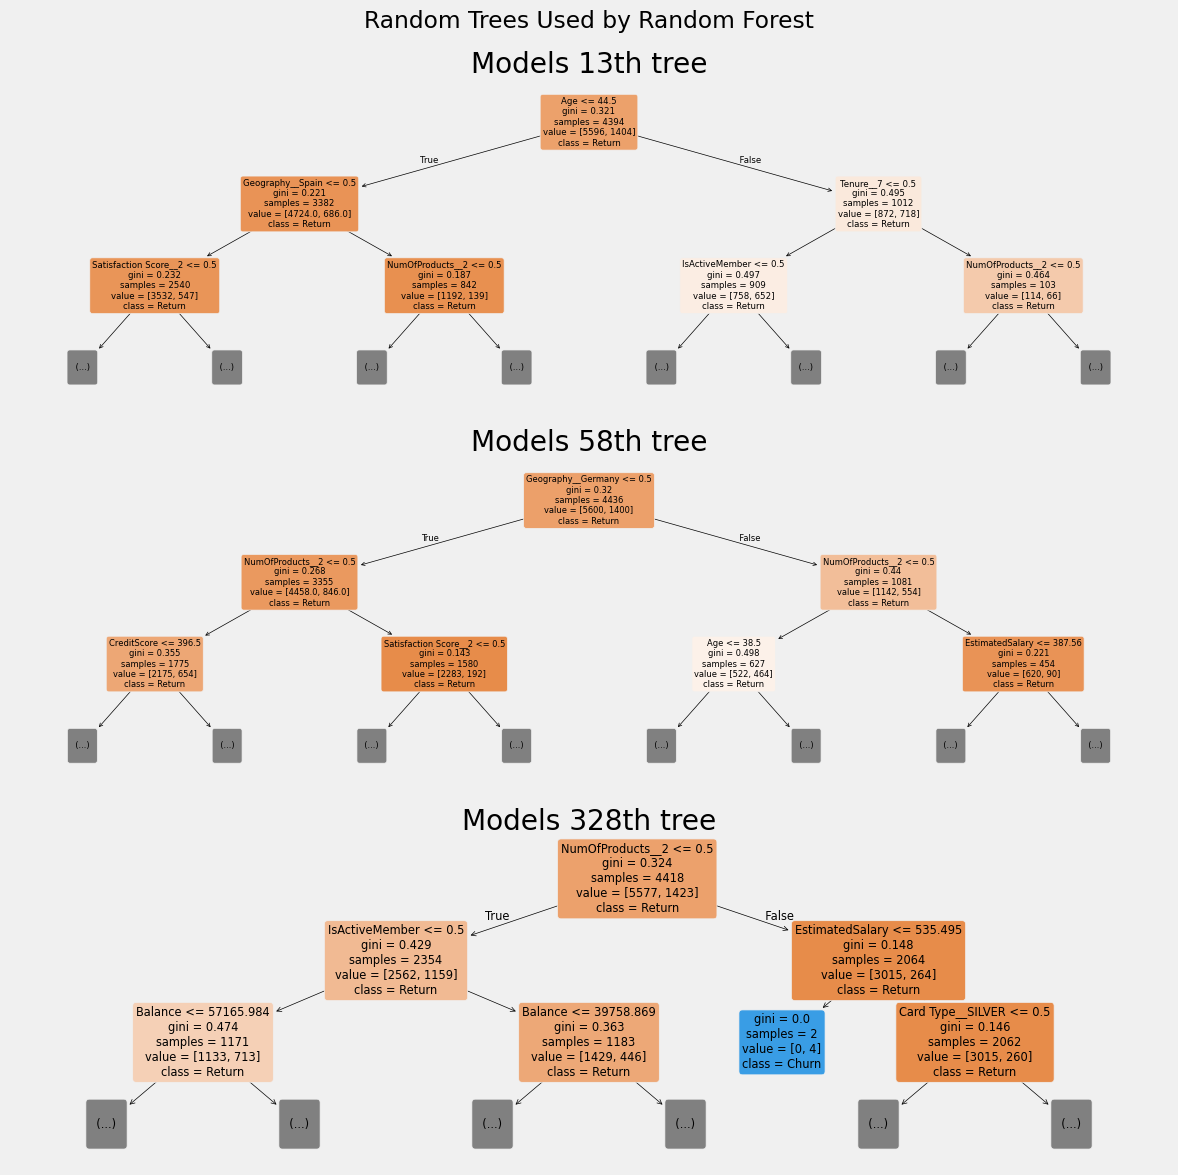

In [14]:
# Visualize rfr's decision tree's processes
print(f"Number of estimators: {len(rfr_best.estimators_)}")


# Randomly choose 2 estimators to visualize
random.seed(42)
tree_index = sorted(random.sample(range(len(rfr_best.estimators_)), 3))

tree_index

## Create plot
fig, ax = plt.subplots(3, 1, figsize = (12, 12))
fig.suptitle("Random Trees Used by Random Forest")
for i, ind in list(enumerate(tree_index)):
        plot_tree(rfr_best.estimators_[ind],
              max_depth=2,
              filled=True,
              feature_names=X.columns,
              class_names=['Return', 'Churn'], 
              rounded=True,
              ax=ax[i])

        ax[i].set_title(f"Models {ind+1}th tree")

plt.tight_layout()

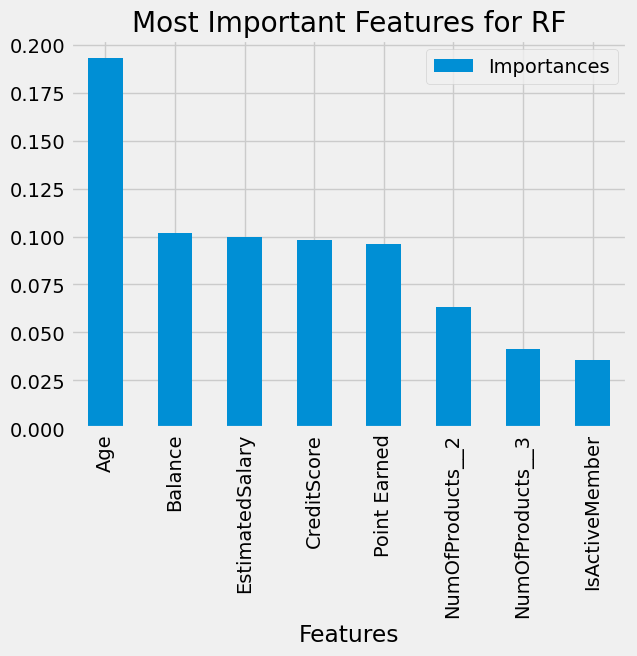

In [15]:
# Lets now plot feature importances
features = X.columns
importances = rfr_best.feature_importances_

feat_imp_df = pd.DataFrame({
    "Features":features,
    "Importances":importances
})

feat_imp_df.sort_values(by='Importances', ascending=False).set_index('Features').head(8).plot(kind='bar', title="Most Important Features for RF")
plt.show()

In [16]:
# Make Predictions
pred = rfr_best.predict(X_test)

In [17]:
print(classification_report(y_test, pred))

# Display accuracy
accuracy = accuracy_score(y_test, pred)
print(f"Accuracy Score: {accuracy}")
print()

              precision    recall  f1-score   support

           0       0.88      0.97      0.92      2389
           1       0.81      0.49      0.61       611

    accuracy                           0.87      3000
   macro avg       0.84      0.73      0.77      3000
weighted avg       0.87      0.87      0.86      3000

Accuracy Score: 0.8726666666666667



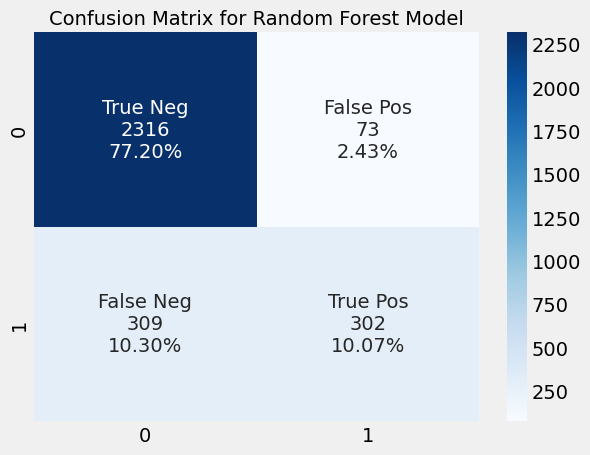

In [18]:
# Confusion Matrix
cfm = confusion_matrix(y_test, pred)

group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in cfm.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in cfm.flatten()/np.sum(cfm)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names, group_counts, group_percentages)]
labels = np.asarray(labels).reshape(cfm.shape)

# Plot
sns.heatmap(cfm, annot=labels, fmt='', cmap='Blues')
plt.title("Confusion Matrix for Random Forest Model",fontsize=14)
plt.show()

# We will now use a gradient boost method to preidct consumer churn

In [19]:
gbc = GradientBoostingClassifier(random_state=42)
gbc

GradientBoostingClassifier(random_state=42)

In [27]:
# KFold for spliting data
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Params for model
param_grid = {
    "loss":['log_loss', 'exponential'],
    "n_estimators":np.arange(100, 525, 25)
}

# Randomly Search for best model
rcv = RandomizedSearchCV(gbc, param_grid, cv=kf, verbose=1, n_jobs=-1)
rcv.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


RandomizedSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
                   estimator=GradientBoostingClassifier(random_state=42),
                   n_jobs=-1,
                   param_distributions={'loss': ['log_loss', 'exponential'],
                                        'n_estimators': array([100, 125, 150, 175, 200, 225, 250, 275, 300, 325, 350, 375, 400,
       425, 450, 475, 500])},
                   verbose=1)

In [28]:
# Display rcv process
data = pd.DataFrame(rcv.cv_results_)
display(data.head().sort_values('rank_test_score'))

# Print results of best model
print(rcv.best_params_)
print(rcv.best_score_)
print(rcv.best_estimator_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_estimators,param_loss,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
3,7.849798,0.503190,0.018771,0.001422,375,exponential,"{'n_estimators': 375, 'loss': 'exponential'}",0.860000,0.859286,0.865714,0.864286,0.847857,0.859429,0.006282,1
0,2.575998,0.087537,0.010163,0.001352,150,exponential,"{'n_estimators': 150, 'loss': 'exponential'}",0.859286,0.862143,0.865714,0.857857,0.850000,0.859000,0.005241,2
1,8.642819,1.086475,0.028835,0.009532,425,exponential,"{'n_estimators': 425, 'loss': 'exponential'}",0.860000,0.861429,0.863571,0.863571,0.846429,0.859000,0.006430,2
4,8.672249,0.459688,0.032966,0.025265,400,exponential,"{'n_estimators': 400, 'loss': 'exponential'}",0.860714,0.860000,0.863571,0.863571,0.847143,0.859000,0.006105,2
2,3.698619,0.565366,0.013552,0.002091,175,log_loss,"{'n_estimators': 175, 'loss': 'log_loss'}",0.856429,0.855714,0.862857,0.859286,0.851429,0.857143,0.003807,10


{'n_estimators': 375, 'loss': 'exponential'}
0.8594285714285714
GradientBoostingClassifier(loss='exponential', n_estimators=375,
                           random_state=42)


In [29]:
# Fit best GradientBoosted Model Data
clf = rcv.best_estimator_
clf

GradientBoostingClassifier(loss='exponential', n_estimators=375,
                           random_state=42)

In [30]:
# Fit and Score manually
clf.fit(X_train, y_train)

print(f"Gradient Boosting Training Score: {clf.score(X_train, y_train)}")
print(f"Gradient Boosting Testing Score: {clf.score(X_test, y_test)}")

Gradient Boosting Training Score: 0.8905714285714286
Gradient Boosting Testing Score: 0.8676666666666667


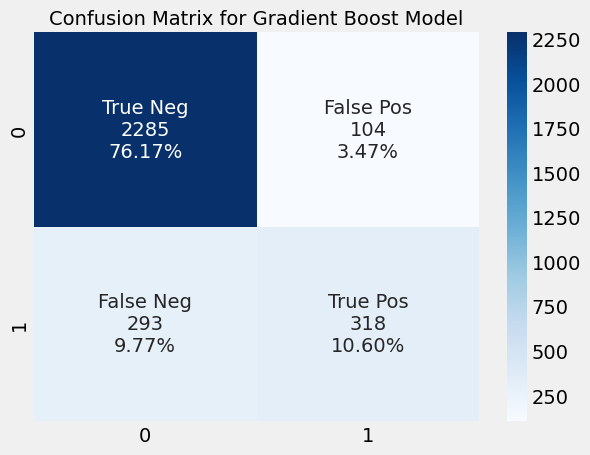

In [31]:
pred = clf.predict(X_test)

# Confusion Matrix
cfm = confusion_matrix(y_test, pred)

group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in cfm.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in cfm.flatten()/np.sum(cfm)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names, group_counts, group_percentages)]
labels = np.asarray(labels).reshape(cfm.shape)

# Plot
sns.heatmap(cfm, annot=labels, fmt='', cmap='Blues')
plt.title("Confusion Matrix for Gradient Boost Model",fontsize=14)
plt.show()

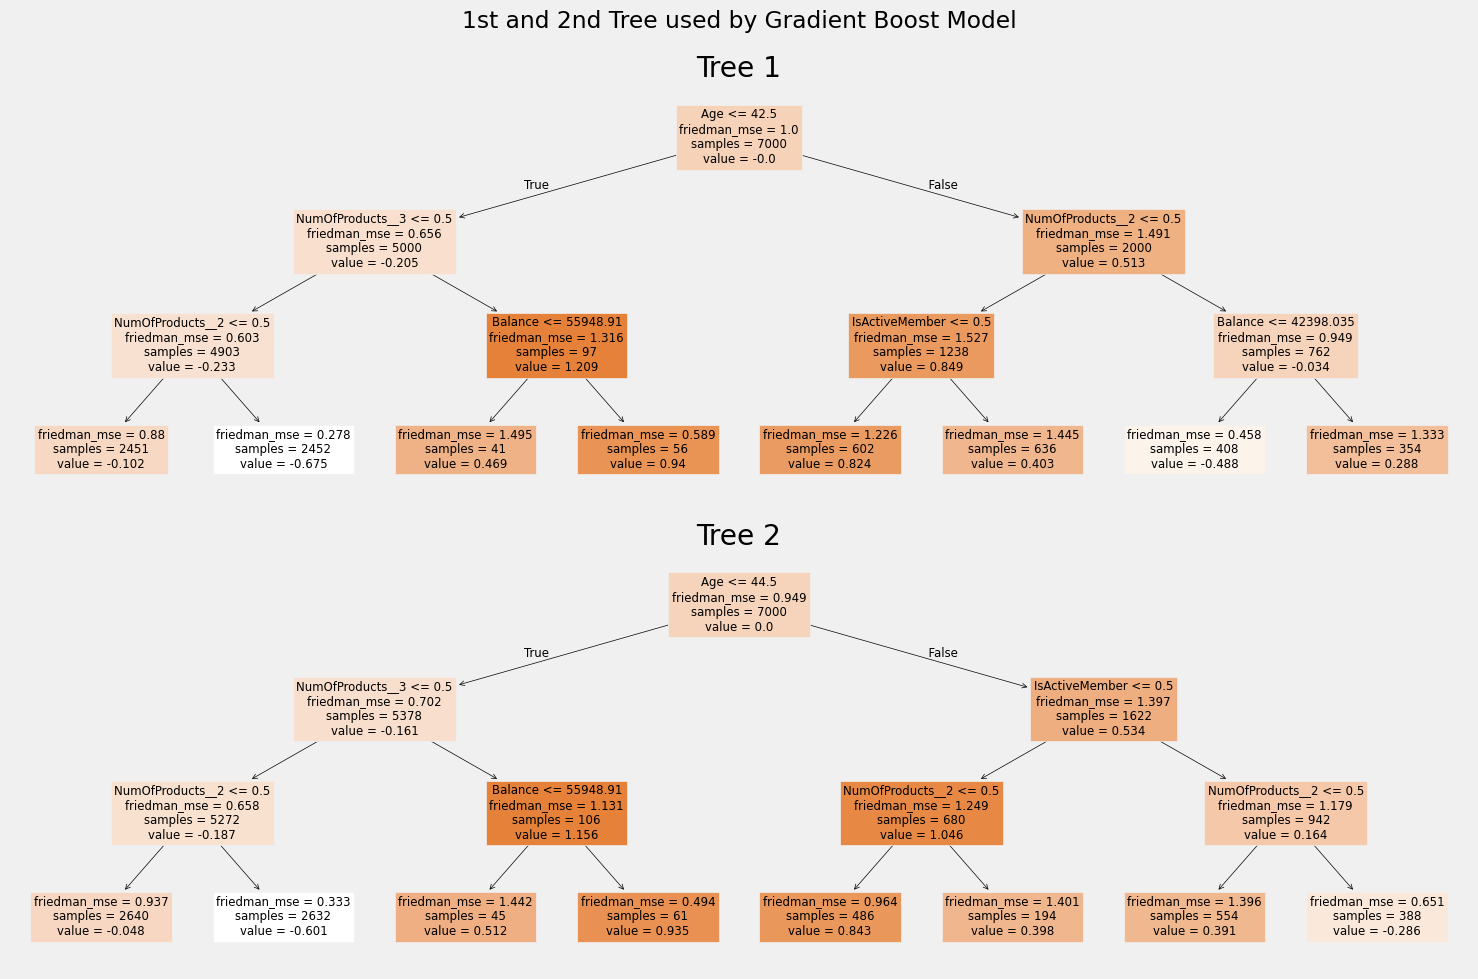

In [32]:
# Plot trees invlolved
n_trees = 2  

fig, ax = plt.subplots(n_trees, 1, figsize=(15, n_trees * 5))
fig.suptitle("1st and 2nd Tree used by Gradient Boost Model")

for i in range(n_trees):
    plot_tree(clf.estimators_[i, 0], 
              filled=True, 
              feature_names=X.columns, 
              class_names=["Return", "Churn"],
              ax=ax[i])
    ax[i].set_title(f"Tree {i+1}")

plt.tight_layout()
plt.show()

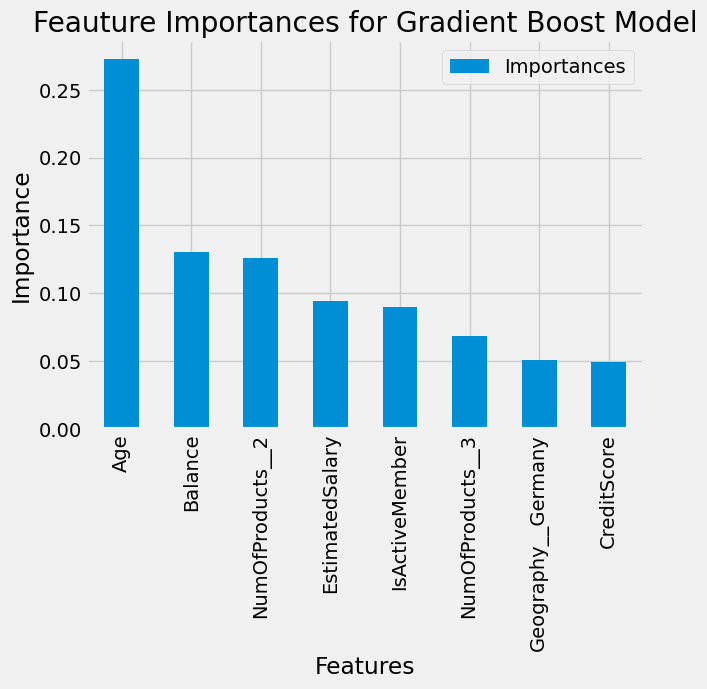

In [33]:
# Lets Finally Plot Feature Importances
features = X.columns
importances = clf.feature_importances_

importances_df = pd.DataFrame({
    "Features" : features,
    "Importances":importances
})

importances_df.sort_values(by="Importances", ascending=False).set_index("Features").head(8).plot(kind='bar', title = "Feauture Importances for Gradient Boost Model")
plt.ylabel("Importance")
plt.show()